### BERT - Bidirectional Encoder Representations from Transformers

In [1]:
# импорт пакетов
%pip install torch torchvision matplotlib numpy scikit-learn seaborn transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

### Importing necessary libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Используемое устройство:", device)

Используемое устройство: cuda


### Outputting the first 10 comments to see structure of dataset

In [4]:
# Enable cuDNN optimizations
torch.backends.cudnn.benchmark = True

# Load dataset
df = pd.read_csv("dataset/labeled.csv")
df = df.dropna()

df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


### Tokenizer from Hugging Face

In [5]:
X = df["comment"].values
y = df["toxic"].values

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruBert-base")
MAX_LEN = 128

def tokenize(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors='pt')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

In [6]:
# Dataset class
class ToxicDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = tokenize(text)

        return {
             "text": text,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.float)
        }

### Splitting training and testing datasets

In [7]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
train_dataset = ToxicDataset(X_train, y_train)
val_dataset = ToxicDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
# Print dataset sizes
print(f"Training Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")

train_labels = [sample['label'] for sample in train_dataset]
val_labels = [sample['label'] for sample in val_dataset]


Training Dataset Size: 11529
Validation Dataset Size: 2883


### Checking distribution of classes (might need to either undersampling or oversampling)

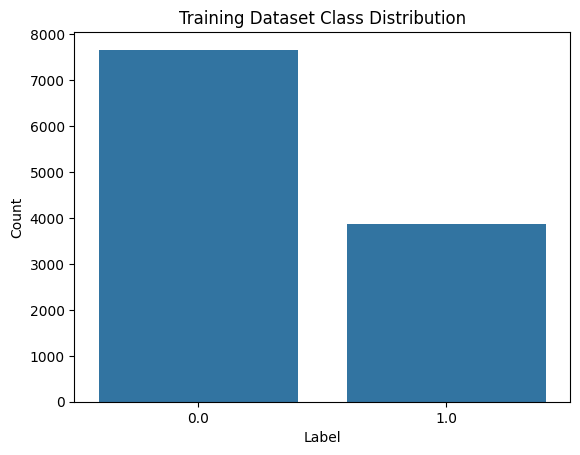

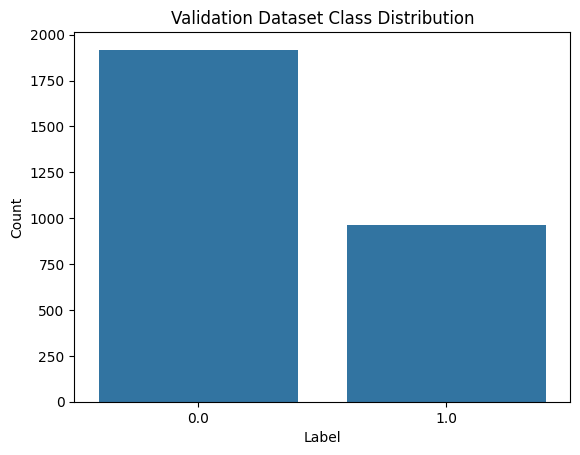

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution in the training dataset
sns.countplot(x=train_labels)
plt.title("Training Dataset Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot class distribution in the validation dataset
sns.countplot(x=val_labels)
plt.title("Validation Dataset Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [10]:
# Print a few samples from the training dataset
print("Training Dataset Samples:")
for i in range(3):  # Print first 3 samples
    sample = train_dataset[i]
    print(f"Sample {i+1}:")
    print(f"  Text: {sample['text']}")
    print(f"  Attention Masks: {sample['attention_mask']}")
    print(f"  Label: {sample['label']}")
    print("-" * 50)

# Print a few samples from the validation dataset
print("Validation Dataset Samples:")
for i in range(3):  # Print first 3 samples
    sample = val_dataset[i]
    print(f"Sample {i+1}:")
    print(f"  Attention Masks: {sample['attention_mask']}")
    print(f"  Text: {sample['text']}")
    print(f"  Label: {sample['label']}")
    print("-" * 50)

Training Dataset Samples:
Sample 1:
  Text: Вы читали закон о банкротстве? Что бы объявить банкротом нужно обратиться в Арбитражный суд с соответствующим заявлением, далее суд потребует внести на свой депозит сумму, обычно не менее 300т.р для обеспечения выплат арбитражному управляющему, если сумма не вносится, то в возбуждение дела о банкротстве откажут. Поэтому надо подавать в суд, затем исполнительный лист приставам и требовать наложение ареста на расчетный счет и если повезет, то появившиеся на счету деньги перечислят истцу.

  Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
  Label: 0.0

### Oversampling to match majority class

In [11]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_train = pd.DataFrame({'text': X_train, 'label': y_train})
df_majority = df_train[df_train['label'] == 0]  # Toxic comments
df_minority = df_train[df_train['label'] == 1]  # Positive comments

# Oversample the minority class
df_minority_oversampled = resample(df_minority,
                                   replace=True,  # With replacement
                                   n_samples=len(df_majority),  # Match majority class size
                                   random_state=42)

# Combine the oversampled minority class with the majority class
df_balanced = pd.concat([df_majority, df_minority_oversampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42)

# Split back into X_train and y_train
X_train_balanced = df_balanced['text'].values
y_train_balanced = df_balanced['label'].values

# Create a new balanced dataset
train_dataset_balanced = ToxicDataset(X_train_balanced, y_train_balanced)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


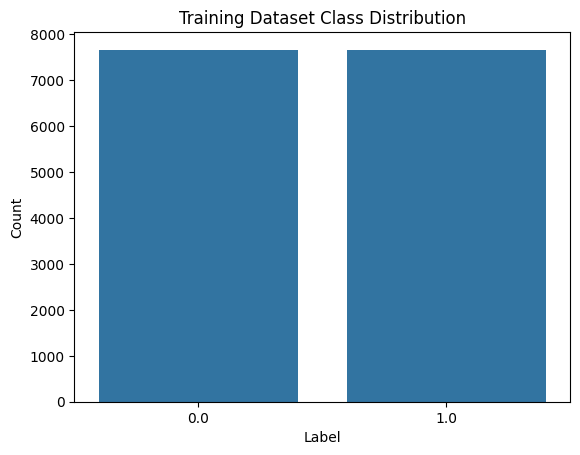

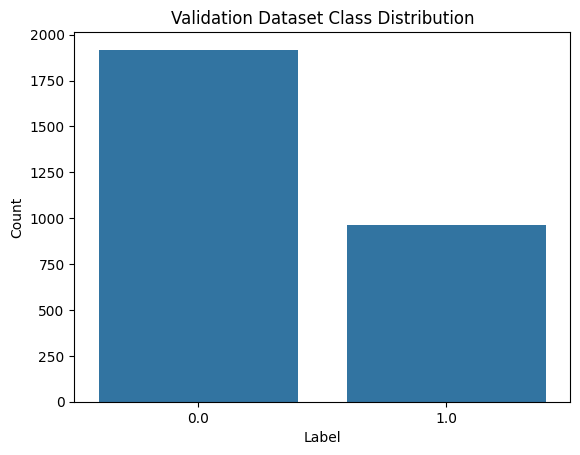

In [12]:
train_labels = [sample['label'] for sample in train_dataset_balanced]
val_labels = [sample['label'] for sample in val_dataset]


# Plot class distribution in the training dataset
sns.countplot(x=train_labels)
plt.title("Training Dataset Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Plot class distribution in the validation dataset
sns.countplot(x=val_labels)
plt.title("Validation Dataset Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


### Custom BERT Model

In [13]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("ai-forever/ruBert-base")
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        cls_output = self.dropout(cls_output)
        out = self.fc(cls_output)
        return out


In [14]:
# Training setup
model = BERTClassifier().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()
scaler = torch.amp.GradScaler()


pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

### Training

In [18]:
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            print(f"Processing batch {batch_idx + 1}/{len(train_loader)}")
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.squeeze(), labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


### Testing

In [19]:
# Evaluation
def evaluate(model, val_loader):
    model.eval()
    all_preds, all_labels = [], []
    original_labels_preds_texts = []  # To store original labels, predictions, and text


    with torch.no_grad():
        for batch in val_loader:
            text, inputs, attention_mask, labels = batch["text"], batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

            with torch.amp.autocast('cuda'):
                outputs = model(inputs, attention_mask).squeeze()
                probs = torch.sigmoid(outputs)
                preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(labels)):
              original_labels_preds_texts.append((labels[i].item(), preds[i].item(), text[i]))

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)

    print(f"Accuracy: {acc}, F1: {f1}, ROC-AUC: {roc_auc}, PR-AUC: {pr_auc}")

     # Print top 10 original labels, predictions, and text
    print("\nTop 10 Original Labels, Predictions, and Text:")
    for i, (label, pred, text) in enumerate(original_labels_preds_texts[:10]):
        print(f"Sample {i+1}:")
        print(f"  Text: {text}")
        print(f"  Label: {label}, Prediction: {pred}")
        print("-" * 50)  # Separator for readability

In [20]:
train(model, train_loader_balanced, criterion, optimizer)

Streaming output truncated to the last 5000 lines.
Processing batch 755/1917
Processing batch 756/1917
Processing batch 757/1917
Processing batch 758/1917
Processing batch 759/1917
Processing batch 760/1917
Processing batch 761/1917
Processing batch 762/1917
Processing batch 763/1917
Processing batch 764/1917
Processing batch 765/1917
Processing batch 766/1917
Processing batch 767/1917
Processing batch 768/1917
Processing batch 769/1917
Processing batch 770/1917
Processing batch 771/1917
Processing batch 772/1917
Processing batch 773/1917
Processing batch 774/1917
Processing batch 775/1917
Processing batch 776/1917
Processing batch 777/1917
Processing batch 778/1917
Processing batch 779/1917
Processing batch 780/1917
Processing batch 781/1917
Processing batch 782/1917
Processing batch 783/1917
Processing batch 784/1917
Processing batch 785/1917
Processing batch 786/1917
Processing batch 787/1917
Processing batch 788/1917
Processing batch 789/1917
Processing batch 790/1917
Processing ba

In [21]:
evaluate(model, val_loader)

Accuracy: 0.9136316337148803, F1: 0.8688783570300158, ROC-AUC: 0.89904612425508, PR-AUC: 0.8037113632339513

Top 10 Original Labels, Predictions, and Text:
Sample 1:
  Text: Увы-увы. Для этого нужно придумать сверхъестественные силы. А для этого нужно, как минимум, знать, какие силы сверхъестественные, а какие - нет. А зачем? Вон, в Африке верили что если сделать вышку из пальмы и посадить на неё человека с наушниками из кокоса, то несомненно прилетят великие духи и сбросят с неба парашют с грузом консервов. У белых это работало, значит, и у нас получится!Силы, что характерно, вполне реальные и называются ВВС США. А вот отношение к ним в культе карго - вполне себе мистическое и ритуализированное.

  Label: 0.0, Prediction: 0.0
--------------------------------------------------
Sample 2:
  Text: Вы просто не умеете читать между строк.

  Label: 0.0, Prediction: 0.0
--------------------------------------------------
Sample 3:
  Text: СРОЧНА!!!!!!!!!!!!!!!!!!!!!!!!!! ИЗБИЕНИЕ И!З!Б!И!Е!Н!